In [ ]:
from pathlib import Path

# 1. Trouve dynamiquement la racine du projet (contenant .gitignore)
cwd = Path.cwd()
PROJECT_ROOT = next(p for p in (cwd, *cwd.parents) if (p / ".gitignore").exists())

print("PROJECT_ROOT =", PROJECT_ROOT)

PROJECT_ROOT = /Users/mackjb/repository/datasciencetest_reco_plante


In [37]:
from pathlib import Path
import pandas as pd
import plotly.express as px
import os
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2



In [50]:

def count_spatial_color_clusters(img_path, color_lower, color_upper, eps=20, min_samples=100):
    """
    img_path : chemin de l'image
    color_lower, color_upper : seuils en HSV pour isoler la couleur feuille (exemple vert)
    eps : distance max en pixels pour DBSCAN
    min_samples : taille minimale d'un cluster pour le garder
    """

    # Charger et convertir en HSV
    img = cv2.imread(img_path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Masque couleur (ex: vert)
    mask = cv2.inRange(hsv, color_lower, color_upper)
    coords = np.column_stack(np.where(mask > 0))  # coordonnées (y,x) des pixels verts

    if len(coords) == 0:
        return 0, mask  # pas de pixels verts détectés

    # DBSCAN sur les coordonnées spatiales (y,x)
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(coords)

    labels = clustering.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # -1 = bruit

    # Visualisation simple des clusters
    clustered_img = np.zeros_like(mask)
    for label in set(labels):
        if label == -1:
            continue  # ignorer bruit
        cluster_coords = coords[labels == label]
        for y, x in cluster_coords:
            clustered_img[y, x] = 255  # blanc pour clusters

    return n_clusters

# Définition des seuils HSV pour détecter le vert (à ajuster selon ton image)
lower_green = np.array([30, 40, 40])   # teinte, saturation, valeur min
upper_green = np.array([90, 255, 255]) # teinte, saturation, valeur max

In [ ]:
import numpy as np
from PIL import Image

# Après avoir binaire l’image (seuillage) segmented, il suffit de regarder si des pixels “feuille” sont présents sur les bords (haut, bas, gauche, droite).
def touches_border(img_path, threshold=10):
    img = Image.open(img_path).convert('L')
    arr = np.array(img)
    mask = arr > threshold  # Pixels de la feuille (fond noir = 0)
    h, w = mask.shape

    touches = {
        'top': mask[0, :].any(),
        'bottom': mask[-1, :].any(),
        'left': mask[:, 0].any(),
        'right': mask[:, -1].any()
    }
    return any(touches.values()), touches



In [52]:

# Chemin vers le dossier principal PlantVillage
# root_dir = PROJECT_ROOT / "dataset" / "plantvillage" / "data" / "plantvillage dataset" / "segmented"
root_dir = PROJECT_ROOT / "dataset" / "plantvillage" / "data" / "plantvillage_5images" / "segmented"



data = []

for subdir, dirs, files in os.walk(root_dir):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            filepath = os.path.join(subdir, file)
            rel_path = os.path.relpath(filepath, root_dir)
            parts = rel_path.split(os.sep)

            # Cas 1 : PlantVillage/Strawberry___healthy/image.jpg
            if len(parts) >= 2 and "___" in parts[0]:
                # format: class___disease/filename
                class_disease = parts[0]
                plant_class, disease = class_disease.split('___', 1)
            # Cas 2 : PlantVillage/Strawberry/healthy/image.jpg
            elif len(parts) >= 3:
                plant_class, disease = parts[0], parts[1]
            # Cas fallback
            else:
                plant_class, disease = parts[0], None

            ext = os.path.splitext(file)[-1].lower().replace('.', '')

            try:
                with Image.open(filepath) as img:
                    width, height = img.size
                    # Optionnel : is_centered (pas modifié ici)
            except Exception as e:
                width, height = None, None

            data.append({
                "filepath": filepath,
                "filename": file,
                "class": plant_class,
                "disease": disease,
                "extension": ext,
                "width": width,
                "height": height,
                "touches_border": touches_border(filepath),
                "number_pieces": count_spatial_color_clusters(
    img_path=filepath,
    color_lower=lower_green,
    color_upper=upper_green,
    eps=30,           # distance max en pixels pour regrouper points dans un cluster
    min_samples=500   # taille min d'un cluster pour être considéré valide
)
            })
pd.set_option('display.max_colwidth', None)
df = pd.DataFrame(data)
df.head(1)


NameError: name 'DBSCAN' is not defined

In [49]:
df_sorted = df.sort_values(by="filepath", ascending=True)
df_sorted.head()

,filepath,filename,class,disease,extension,width,height,touches_border,number_pieces
127,/Users/mackjb/repository/datasciencetest_reco_plante/dataset/plantvillage/data/plantvillage_5images/segmented/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335_final_masked.jpg,00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335_final_masked.jpg,Apple,Apple_scab,jpg,256,256,"(True, {'top': False, 'bottom': True, 'left': False, 'right': False})",19
126,/Users/mackjb/repository/datasciencetest_reco_plante/dataset/plantvillage/data/plantvillage_5images/segmented/Apple___Apple_scab/01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab 3003_final_masked.jpg,01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab 3003_final_masked.jpg,Apple,Apple_scab,jpg,256,256,"(True, {'top': False, 'bottom': True, 'left': True, 'right': True})",11
129,/Users/mackjb/repository/datasciencetest_reco_plante/dataset/plantvillage/data/plantvillage_5images/segmented/Apple___Apple_scab/01f3deaa-6143-4b6c-9c22-620a46d8be04___FREC_Scab 3112_final_masked.jpg,01f3deaa-6143-4b6c-9c22-620a46d8be04___FREC_Scab 3112_final_masked.jpg,Apple,Apple_scab,jpg,256,256,"(True, {'top': False, 'bottom': True, 'left': True, 'right': False})",27
125,/Users/mackjb/repository/datasciencetest_reco_plante/dataset/plantvillage/data/plantvillage_5images/segmented/Apple___Apple_scab/0208f4eb-45a4-4399-904e-989ac2c6257c___FREC_Scab 3037_final_masked.jpg,0208f4eb-45a4-4399-904e-989ac2c6257c___FREC_Scab 3037_final_masked.jpg,Apple,Apple_scab,jpg,256,256,"(True, {'top': False, 'bottom': True, 'left': False, 'right': False})",12
128,/Users/mackjb/repository/datasciencetest_reco_plante/dataset/plantvillage/data/plantvillage_5images/segmented/Apple___Apple_scab/023123cb-7b69-4c9f-a521-766d7c8543bb___FREC_Scab 3487_final_masked.jpg,023123cb-7b69-4c9f-a521-766d7c8543bb___FREC_Scab 3487_final_masked.jpg,Apple,Apple_scab,jpg,256,256,"(True, {'top': False, 'bottom': True, 'left': True, 'right': False})",15


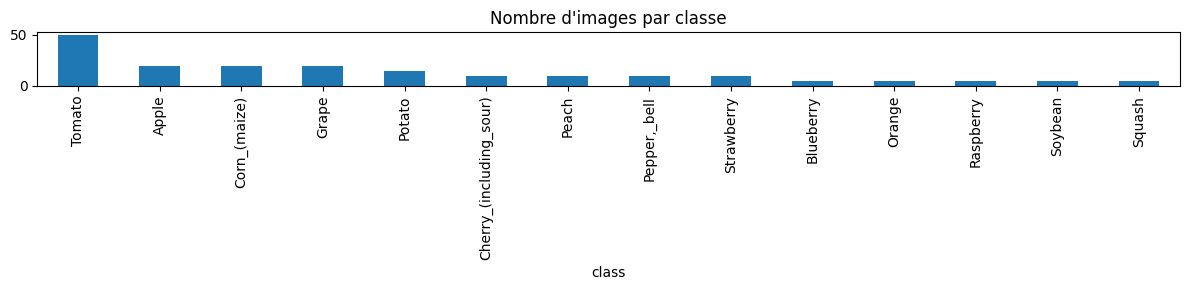

In [46]:
df.groupby("class")["filename"].count().sort_values(ascending=False).plot(kind='bar', figsize=(12,3), title="Nombre d'images par classe")
plt.tight_layout()
plt.show()

/var/folders/3c/g0xfydzx0ql5lty6fzv7sbqc0000gn/T/ipykernel_82368/1391405169.py:2: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


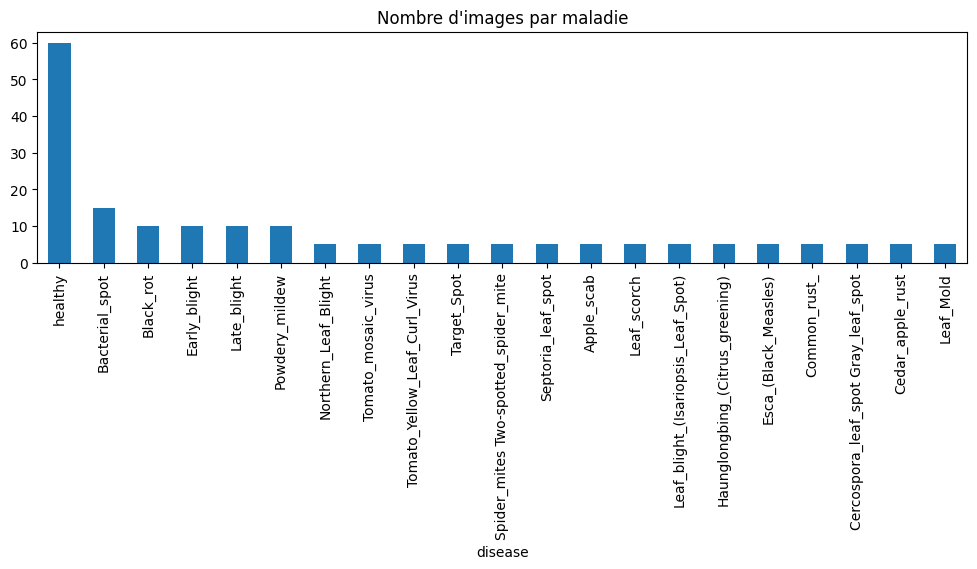

In [47]:
df.groupby("disease")["filename"].count().sort_values(ascending=False).plot(kind='bar', figsize=(12,3), title="Nombre d'images par maladie")
plt.tight_layout()
plt.show()

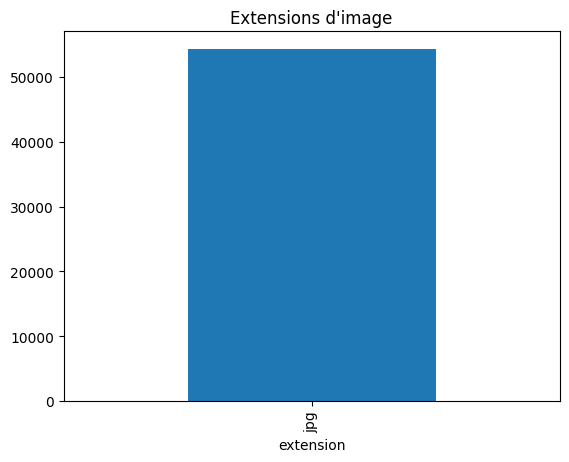

In [26]:
df["extension"].value_counts().plot(kind='bar', title="Extensions d'image")
plt.show()

<Axes: title={'center': 'Résolution des images'}, xlabel='width,height'>

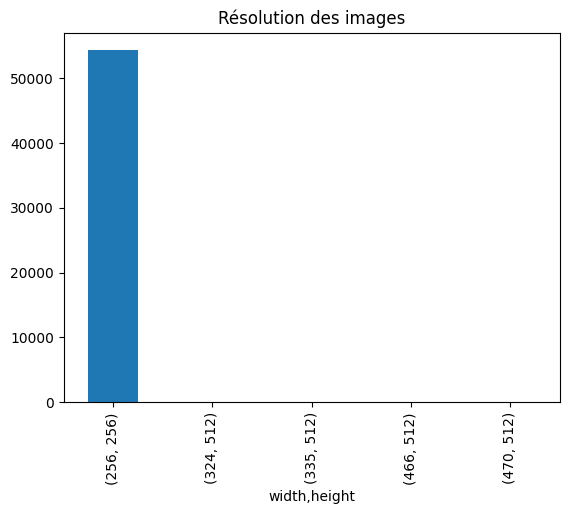

In [29]:
df[["width", "height"]].value_counts().plot(kind='bar', title="Résolution des images")